In [52]:
import config as c
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# Descriptive Analysis
- demographic data
- fitts' law
    - effective id
    - task completion time (overall & per id)
    - error rate (overall & per id)
    - throughput (overall & per id)
    - regression of error rate
    - regression of task completion time
- nasa-tlx

## Analysis of Demographic Data

In [53]:
demographic_df = pd.DataFrame()
for id in range(c.NUM_PARTICIPANTS):
    demographic_raw = pd.read_csv(
        c.FOLDER_PATH
        + str(id + 1)
        + f"/demographic_participant_{id + 1}.csv"
    )
    demographic_df = pd.concat([demographic_df, demographic_raw])

demographic_df.head()

,participant_id,agreed,age,gender,hand,input_device,mouse
0,1,True,23,male,right,Mouse,often
0,2,True,26,female,right,Touchpad,never
0,3,True,25,male,right,Mouse,often
0,4,True,24,male,right,Mouse,often
0,5,True,24,female,right,Touchpad,never


In [54]:
mean_age = np.mean(demographic_df["age"])
std_age = np.std(demographic_df["age"])
print("Average age: ", mean_age, " (Std: ", std_age, ")")
print(
    "Gender: \n",
    demographic_df["gender"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "value", 0: "count"}),
)
print(
    "Handedness: \n",
    demographic_df["hand"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "value", 0: "count"}),
)
print(
    "Most used input device: \n",
    demographic_df["input_device"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "value", 0: "count"}),
)
print(
    "Frequency of mouse input: \n",
    demographic_df["mouse"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "value", 0: "count"}),
)

Average age:  24.5  (Std:  0.9574271077563381 )
Gender: 
    gender  count
0    male      4
1  female      2
Handedness: 
     hand  count
0  right      6
Most used input device: 
   input_device  count
0        Mouse      4
1     Touchpad      2
Frequency of mouse input: 
    mouse  count
0  often      4
1  never      2


## Analyis of Fitts' Law 

In [58]:
latency_conditions = [-40, -20, 0, 20, 40]
balanced_latin_square = [[0,1,4,3,2],
                        [4,2,0,3,1],
                        [3,2,1,4,0],
                        [1,0,3,4,2],
                        [4,0,2,1,3],
                        [2,3,4,1,0],
                        [1,3,0,2,4],
                        [0,4,1,2,3],
                        [2,4,3,0,1],
                        [3,1,2,0,4]]

clicks_df = pd.DataFrame()
for id in range(c.NUM_PARTICIPANTS):
    for trial in range(c.NUM_TRIALS):
        clicks_raw = pd.read_csv(
            c.FOLDER_PATH
            + str(id + 1)
            + f"/clicks_participant_{id + 1}_trial_{trial}.csv"
        )
        clicks_raw["level_of_latency"] = latency_conditions[balanced_latin_square[id][trial]]
        clicks_df = pd.concat([clicks_df, clicks_raw])
    
clicks_df.head()

,id,timestamp_ms,participant_id,trial,level_of_latency,target_number,target_width,target_amplitude,target_x,target_y,cursor_x,cursor_y,success,completion_time
0,0,1710166191603,1,0,-40,0,30,450,959,103,957,107,1,1.787344
1,1,1710166193111,1,0,-40,1,30,450,1113,975,1117,968,1,1.508388
2,2,1710166194311,1,0,-40,2,30,450,670,208,672,211,1,1.199971
3,3,1710166196228,1,0,-40,3,30,450,1349,778,1353,787,1,1.916836
4,4,1710166197495,1,0,-40,4,30,450,516,474,519,467,1,1.267135


In [59]:
# drop irrelevant columns
clicks_df = clicks_df.drop(
    ["timestamp_ms", "target_number"], axis=1
)
# drop rows of first click in round (no fitts law task)
clicks_df = clicks_df.drop(clicks_df.loc[clicks_df["id"] % 9 == 0].index, axis=0)
clicks_df.reset_index(inplace=True, drop=True)
clicks_df

,id,participant_id,trial,level_of_latency,target_width,target_amplitude,target_x,target_y,cursor_x,cursor_y,success,completion_time
0,1,1,0,-40,30,450,1113,975,1117,968,1,1.508388
1,2,1,0,-40,30,450,670,208,672,211,1,1.199971
2,3,1,0,-40,30,450,1349,778,1353,787,1,1.916836
3,4,1,0,-40,30,450,516,474,519,467,1,1.267135
4,5,1,0,-40,30,450,1403,474,1409,482,1,1.045496
...,...,...,...,...,...,...,...,...,...,...,...,...
8635,319,6,4,-40,30,200,763,518,758,510,1,0.821035
8636,320,6,4,-40,30,200,1156,518,1144,510,0,0.883963
8637,321,6,4,-40,30,200,786,652,778,652,1,0.932972
8638,322,6,4,-40,30,200,1088,399,1085,392,1,1.191457


In [65]:
# drop rows with unsuccessful fitts law tasks
error_indices = clicks_df.loc[clicks_df["success"]==0].index
task_after_error_indices = clicks_df.loc[clicks_df["success"]==0].index + 1
clicks_error_df = clicks_df.drop(error_indices, axis=0)
clicks_error_df = clicks_df.drop(task_after_error_indices, axis=0)

clicks_error_df.reset_index(inplace=True, drop=True)
clicks_error_df

,id,participant_id,trial,level_of_latency,target_width,target_amplitude,target_x,target_y,cursor_x,cursor_y,success,completion_time
0,1,1,0,-40,30,450,1113,975,1117,968,1,1.508388
1,2,1,0,-40,30,450,670,208,672,211,1,1.199971
2,3,1,0,-40,30,450,1349,778,1353,787,1,1.916836
3,4,1,0,-40,30,450,516,474,519,467,1,1.267135
4,5,1,0,-40,30,450,1403,474,1409,482,1,1.045496
...,...,...,...,...,...,...,...,...,...,...,...,...
8123,318,6,4,-40,30,200,1133,653,1137,650,1,0.978993
8124,319,6,4,-40,30,200,763,518,758,510,1,0.821035
8125,320,6,4,-40,30,200,1156,518,1144,510,0,0.883963
8126,322,6,4,-40,30,200,1088,399,1085,392,1,1.191457


### Overall Fitts' Law Analysis
- Calculation of id
- Calculation of effective id
- Mean error rate
- Mean completion time
- Mean throughput

In [67]:
# calculation of id
clicks_df["ID"] = np.log2(clicks_df["target_amplitude"] / clicks_df["target_width"] + 1)
clicks_error_df["ID"] = np.log2(clicks_error_df["target_amplitude"] / clicks_error_df["target_width"] + 1)

In [ ]:
# calculation of effective id
num_ids = len(clicks_df["ID"].unique())

clicks_df["distance_from_target"] = np.sqrt(
    (clicks_df["target_x"] - clicks_df["cursor_x"])**2 +
    (clicks_df["target_y"] - clicks_df["cursor_y"])**2
)

effective_id_df = pd.DataFrame({"ID": clicks_df["ID"].unique(), 
                                "sigma": np.zeros(num_ids),
                                "amplitude": np.zeros(num_ids),
                                "width": np.zeros(num_ids)})
for _, entry in clicks_df.iterrows():
    for _, row in effective_id_df.iterrows():
        if entry["ID"] == row["ID"]:
            row["amplitude"] = entry["target_amplitude"]
            row["width"] = entry["target_width"]
            row["sigma"] += entry["distance_from_target"]

effective_id_df["sigma"] /= len(clicks_df)/9
effective_id_df["We"] = 4.133 * effective_id_df["sigma"]
effective_id_df["IDe"] = np.log2(
    effective_id_df["amplitude"] / effective_id_df["We"] + 1
)
effective_id_df.sort_values(by=["ID"])

,ID,sigma,amplitude,width,We,IDe
5,1.000000,32.198907,200.0,200.0,133.078082,1.323587
3,1.392317,44.917568,325.0,200.0,185.644308,1.459778
8,1.415037,26.273462,200.0,120.0,108.588218,1.506815
6,1.700440,45.467754,450.0,200.0,187.918226,1.763267
2,1.890771,31.662447,325.0,120.0,130.860892,1.800560
7,2.247928,28.532752,450.0,120.0,117.925862,2.267822
4,2.938599,9.226566,200.0,30.0,38.133397,2.642643
1,3.564785,9.324391,325.0,30.0,38.537707,3.237762
0,4.000000,10.124243,450.0,30.0,41.843497,3.555124


In [ ]:
def calculate_mean_std(arr):
    return round(np.mean(arr), 2), round(np.std(arr), 2)

In [ ]:
# calculation of mean and standard deviation of error rate and completion time
print("Mean error rate: ",  calculate_mean_std(1 - clicks_df["success"]))
print("Mean completion time: ",  calculate_mean_std(clicks_df["completion_time"]))

Mean error rate:  (0.06, 0.24)
Mean completion time:  (0.64, 0.26)


In [69]:
# calculation of throughput
throughput_df = pd.DataFrame({"IDe": np.zeros(clicks_error_df.shape[0]),
                              "completion_time": clicks_error_df["completion_time"]})

for index, entry in clicks_error_df.iterrows():
    for _, row in effective_id_df.iterrows():
        if entry["ID"] == row["ID"]:
            throughput_df.loc[index,"IDe"] = row["IDe"]

throughput_df["throughput"] = throughput_df["IDe"] / throughput_df["completion_time"]
print("Mean throughput: ",  calculate_mean_std(throughput_df["throughput"]))

Mean throughput:  (3.57, 1.01)


In [70]:
error_df = pd.DataFrame({"IDe": np.zeros(clicks_df.shape[0]),
                        "error_rate": 1 - clicks_df["success"]})

for index, entry in clicks_df.iterrows():
    for _, row in effective_id_df.iterrows():
        if entry["ID"] == row["ID"]:
            error_df.loc[index,"IDe"] = row["IDe"]
error_df.head()

,IDe,error_rate
0,3.555124,0
1,3.555124,0
2,3.555124,0
3,3.555124,0
4,3.555124,0
...,...,...
8635,2.642643,0
8636,2.642643,1
8637,2.642643,0
8638,2.642643,0


In [71]:
# calculation of throughput, error rate, completion time per id
ides = throughput_df["IDe"].unique()
throughput_df_per_id = pd.DataFrame({"IDe": ides,
                                     "mean_throughput": np.zeros(len(ides)),
                                     "std_throughput": np.zeros(len(ides)),
                                     "mean_completion_time": np.zeros(len(ides)),
                                     "std_completion_time": np.zeros(len(ides))})
error_df_per_id = pd.DataFrame({"IDe": ides,
                                "mean_error_rate": np.zeros(len(ides)),
                                "std_error_rate": np.zeros(len(ides))})

for _, entry in throughput_df_per_id.iterrows():
    id = entry["IDe"]
    queried_df = throughput_df.query(f"IDe=={id}")
    throughput = queried_df["throughput"]
    completion_time = queried_df["completion_time"]
    entry["mean_throughput"], entry["std_throughput"] = calculate_mean_std(throughput)
    entry["mean_completion_time"], entry["std_completion_time"] = calculate_mean_std(completion_time)

for _, entry in error_df_per_id.iterrows():
    id = entry["IDe"]
    queried_df = error_df.query(f"IDe=={id}")
    error_rate = queried_df["error_rate"]
    entry["mean_error_rate"], entry["std_error_rate"] = calculate_mean_std(error_rate)

throughput_df_per_id["IDe"] = round(throughput_df_per_id["IDe"], 2)
error_df_per_id["IDe"] = round(error_df_per_id["IDe"], 2)
throughput_df_per_id = throughput_df_per_id.sort_values(by=["IDe"])
throughput_df_per_id

,IDe,mean_throughput,std_throughput,mean_completion_time,std_completion_time
5,1.32,3.39,1.15,0.43,0.15
3,1.46,3.42,1.00,0.46,0.13
8,1.51,3.58,1.19,0.46,0.14
6,1.76,3.42,0.94,0.56,0.17
2,1.80,3.40,0.96,0.57,0.16
7,2.27,3.69,0.87,0.65,0.15
4,2.64,3.58,0.92,0.79,0.22
1,3.24,3.89,0.94,0.89,0.24
0,3.56,3.80,0.90,0.99,0.25


In [73]:
error_df_per_id

,IDe,mean_error_rate,std_error_rate
0,3.56,0.14,0.35
1,3.24,0.09,0.29
2,1.80,0.05,0.21
3,1.46,0.03,0.18
4,2.64,0.09,0.29
5,1.32,0.01,0.08
6,1.76,0.04,0.21
7,2.27,0.05,0.22
8,1.51,0.03,0.17


In [ ]:
# calculate throughput per latency condition
throughput_df["level_of_latency"] = clicks_df["level_of_latency"]

print(throughput_df[throughput_df['level_of_latency'] == 40]['throughput'].mean(), throughput_df[throughput_df['level_of_latency'] == 40]['throughput'].std())
print(throughput_df[throughput_df['level_of_latency'] == 20]['throughput'].mean(), throughput_df[throughput_df['level_of_latency'] == 20]['throughput'].std())
print(throughput_df[throughput_df['level_of_latency'] == 0]['throughput'].mean(), throughput_df[throughput_df['level_of_latency'] == 0]['throughput'].std())
print(throughput_df[throughput_df['level_of_latency'] == -20]['throughput'].mean(), throughput_df[throughput_df['level_of_latency'] == -20]['throughput'].std())
print(throughput_df[throughput_df['level_of_latency'] == -40]['throughput'].mean(), throughput_df[throughput_df['level_of_latency'] == -40]['throughput'].std())

3.5779234162479416 1.123816777656302
3.7174835080010826 0.9202009041219188
3.7551814740367635 1.2265009692280033
3.524228761606756 0.806109329772313
3.3609227733915352 0.8916796889874533


In [ ]:
# calculate completion time per latency condition

print(throughput_df[throughput_df['level_of_latency'] == 40]['completion_time'].mean(), throughput_df[throughput_df['level_of_latency'] == 40]['completion_time'].std())
print(throughput_df[throughput_df['level_of_latency'] == 20]['completion_time'].mean(), throughput_df[throughput_df['level_of_latency'] == 20]['completion_time'].std())
print(throughput_df[throughput_df['level_of_latency'] == 0]['completion_time'].mean(), throughput_df[throughput_df['level_of_latency'] == 0]['completion_time'].std())
print(throughput_df[throughput_df['level_of_latency'] == -20]['completion_time'].mean(), throughput_df[throughput_df['level_of_latency'] == -20]['completion_time'].std())
print(throughput_df[throughput_df['level_of_latency'] == -40]['completion_time'].mean(), throughput_df[throughput_df['level_of_latency'] == -40]['completion_time'].std())

0.65324725 0.27432354802545456
0.6076106296296296 0.23187398306463786
0.6254446284722222 0.2641092332829183
0.6411829236111112 0.2523262084616619
0.686020009837963 0.2855728845366036


In [75]:
# calculate error rate per latency condition
error_df["level_of_latency"] = clicks_error_df["level_of_latency"]

print(error_df[error_df['level_of_latency'] == 40]['error_rate'].mean(), error_df[error_df['level_of_latency'] == 40]['error_rate'].std())
print(error_df[error_df['level_of_latency'] == 20]['error_rate'].mean(), error_df[error_df['level_of_latency'] == 20]['error_rate'].std())
print(error_df[error_df['level_of_latency'] == 0]['error_rate'].mean(), error_df[error_df['level_of_latency'] == 0]['error_rate'].std())
print(error_df[error_df['level_of_latency'] == -20]['error_rate'].mean(), error_df[error_df['level_of_latency'] == -20]['error_rate'].std())
print(error_df[error_df['level_of_latency'] == -40]['error_rate'].mean(), error_df[error_df['level_of_latency'] == -40]['error_rate'].std())

0.08553846153846154 0.27976740190084853
0.048810250152532035 0.2155368966991595
0.03380454824830977 0.18078132639844377
0.05240706886045095 0.2229144428430996
0.07769423558897243 0.26777372517018105


## Fitts' Law Regression
- Regression model for error rate
- Regression model for completion time

In [76]:
def model_error_rate(x):
    slope_error_rate, intercept_error_rate, r_error_rate, p, std_err = stats.linregress(
        error_df_per_id["IDe"], error_df_per_id["mean_error_rate"]
    )
    return slope_error_rate * x + intercept_error_rate
slope_error_rate, intercept_error_rate, r_error_rate, p_error, std_err = stats.linregress(
        error_df_per_id["IDe"], error_df_per_id["mean_error_rate"]
    )
p_error

4.4931966546221166e-05

In [ ]:
def model_completion_time(x):
  slope_completion_time, intercept_completion_time, r_completion_time, p, std_err = stats.linregress(
    throughput_df_per_id["IDe"], throughput_df_per_id["mean_completion_time"]
    )
  return slope_completion_time * x + intercept_completion_time
slope_completion_time, intercept_completion_time, r_completion_time, p_time, std_err = stats.linregress(
    throughput_df_per_id["IDe"], throughput_df_per_id["mean_completion_time"]
    )
p_error

4.4931966546221166e-05

In [77]:
ide = effective_id_df["IDe"]
completion_time = throughput_df_per_id["mean_completion_time"]
e_completion_time = throughput_df_per_id["std_completion_time"] * 1.96 / np.sqrt(throughput_df_per_id.shape[1])
error_rate = error_df_per_id["mean_error_rate"]
e_error_rate = error_df_per_id["std_error_rate"] * 1.96 / np.sqrt(error_df_per_id.shape[1])

regr_completion_time = list(map(model_completion_time, ide))
regr_error_rate = list(map(model_error_rate, ide))

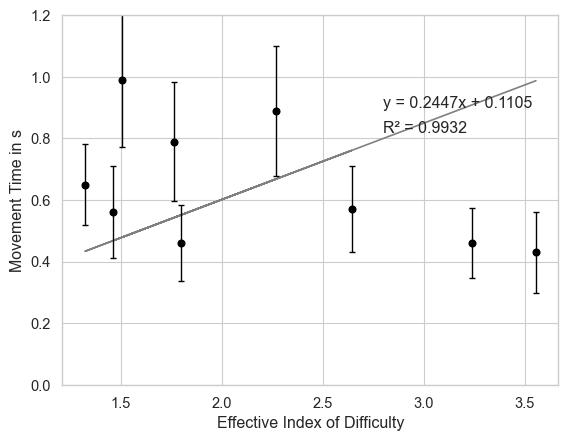

In [78]:
# regression plot for completion time
sns.set_theme(style='whitegrid', font_scale=1.2, context='paper')

plt.plot(ide, regr_completion_time, color="grey")
plt.errorbar(ide, completion_time, e_completion_time, linestyle='None', capsize=2, fmt="o", color="black", elinewidth=1)
plt.xlabel("Effective Index of Difficulty")
plt.ylabel("Movement Time in s")

plt.ylim(0, 1.2)
plt.text(2.8, 0.82, 'R² = '+ str(round(r_completion_time**2, 4)))
plt.text(2.8, 0.9, 'y = '+ str(round(slope_completion_time, 4)) + "x + " + str(round(intercept_completion_time, 4)))
plt.savefig('figures/regression_completion_time.pdf', bbox_inches='tight')
plt.show()

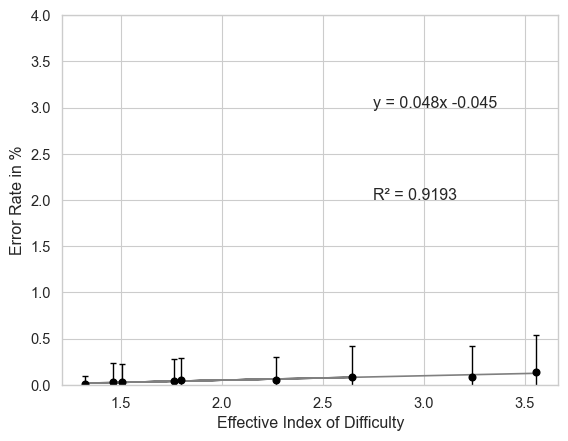

In [86]:
# regression plot for error rate
sns.set_theme(style='whitegrid', font_scale=1.2, context='paper')

plt.plot(ide, regr_error_rate, color="grey")
plt.errorbar(ide, error_rate, e_error_rate, linestyle='None', capsize=2, fmt="o", color="black", elinewidth=1)
plt.xlabel("Effective Index of Difficulty")
plt.ylabel("Error Rate in %")

plt.ylim(0, 4)
plt.text(2.75, 2, 'R² = '+ str(round(r_error_rate**2, 4)))
plt.text(2.75, 3, 'y = '+ str(round(slope_error_rate, 3)) + "x " + str(round(intercept_error_rate, 3)))
plt.savefig('figures/regression_error_rate.pdf', bbox_inches='tight')
plt.show()

## NASA-TLX

In [ ]:
tlx_df = pd.DataFrame()
for id in range(c.NUM_PARTICIPANTS):
    tlx_raw = pd.read_csv(
        c.FOLDER_PATH
        + str(id + 1)
        + f"/tlx_participant_{id + 1}.csv"
    )
    tlx_raw["level_of_latency"] = balanced_latin_square[id]
    tlx_df = pd.concat([tlx_df, tlx_raw])

tlx_df.head()

,participant_id,trial,latency,mental_demand,physical_demand,temporal_demand,performance,effort,frustration,level_of_latency
0,1,0,0,8.0,10.0,16.2,2.0,13.0,4.8,0
1,1,1,0,14.0,10.8,14.2,8.4,12.2,11.2,1
2,1,2,0,16.4,15.8,8.6,12.2,14.0,8.6,4
3,1,3,0,10.8,13.0,4.6,6.6,11.0,4.0,3
4,1,4,0,8.2,8.2,12.2,6.2,7.0,4.4,2


In [ ]:
tlx_df.drop(["participant_id", "latency"], axis=1, inplace=True)

In [ ]:
# calculate overall scores
overall_tlx_df = tlx_df.drop(["trial"], axis=1)
for score in overall_tlx_df.columns:
    mean, std = calculate_mean_std(overall_tlx_df[score])
    print(score + ": " + str(mean) + " (" + str(std) + ")")

mean, std = calculate_mean_std(overall_tlx_df.to_numpy())
print("overall score: "+ str(mean) + " (" + str(std) + ")")

mental_demand: 7.75 (5.46)
physical_demand: 6.01 (5.02)
temporal_demand: 4.62 (4.75)
performance: 7.23 (4.07)
effort: 7.33 (4.15)
frustration: 7.54 (4.4)
level_of_latency: 2.0 (1.41)
overall score: 6.07 (4.77)


In [ ]:
# calculate scores per trial
trial = 0
trials = tlx_df["trial"].unique()
tlx_trial_df = pd.DataFrame(
    {
        "trial": trials,
        "mean_score": np.zeros(len(trials)),
        "mean_mental_demand": np.zeros(len(trials)),
        "mean_physical_demand": np.zeros(len(trials)),
        "mean_temporal_demand": np.zeros(len(trials)),
        "mean_performance": np.zeros(len(trials)),
        "mean_effort": np.zeros(len(trials)),
        "mean_frustration": np.zeros(len(trials)),
    }
)

tlx_std_trial_df = pd.DataFrame(
    {
        "trials": trials,
        "std_score": np.zeros(len(trials)),
        "std_mental_demand": np.zeros(len(trials)),
        "std_physical_demand": np.zeros(len(trials)),
        "std_temporal_demand": np.zeros(len(trials)),
        "std_performance": np.zeros(len(trials)),
        "std_effort": np.zeros(len(trials)),
        "std_frustration": np.zeros(len(trials)),
    }
)

for level_of_latency in tlx_df["level_of_latency"].unique():
    trial_df = tlx_df.query(f"level_of_latency=={level_of_latency}").drop(["level_of_latency"], axis=1)

    (
        tlx_trial_df.loc[trial, "mean_score"],
        tlx_std_trial_df.loc[trial, "std_score"],
    ) = calculate_mean_std(trial_df.to_numpy())


    (
        tlx_trial_df.loc[trial, "mean_mental_demand"],
        tlx_std_trial_df.loc[trial, "std_mental_demand"],
    ) = calculate_mean_std(trial_df["mental_demand"])

    (
        tlx_trial_df.loc[trial, "mean_physical_demand"],
        tlx_std_trial_df.loc[trial, "std_physical_demand"],
    ) = calculate_mean_std(trial_df["physical_demand"])

    (
        tlx_trial_df.loc[trial, "mean_temporal_demand"],
        tlx_std_trial_df.loc[trial, "std_temporal_demand"],
    ) = calculate_mean_std(trial_df["temporal_demand"])

    (
        tlx_trial_df.loc[trial, "mean_performance"],
        tlx_std_trial_df.loc[trial, "std_performance"],
    ) = calculate_mean_std(trial_df["performance"])

    (
        tlx_trial_df.loc[trial, "mean_effort"],
        tlx_std_trial_df.loc[trial, "std_effort"],
    ) = calculate_mean_std(trial_df["effort"])

    (
        tlx_trial_df.loc[trial, "mean_frustration"],
        tlx_std_trial_df.loc[trial, "std_frustration"],
    ) = calculate_mean_std(trial_df["frustration"])
    trial+=1

In [ ]:
tlx_trial_df

,trial,mean_score,mean_mental_demand,mean_physical_demand,mean_temporal_demand,mean_performance,mean_effort,mean_frustration
0,0,6.02,7.60,5.93,4.90,7.03,7.33,7.37
1,1,6.80,9.30,6.83,4.63,7.37,8.67,8.63
2,2,6.63,8.67,6.50,4.77,9.43,7.37,8.00
3,3,5.63,6.93,5.50,4.97,6.00,6.50,7.33
4,4,5.25,6.23,5.27,3.83,6.30,6.77,6.37


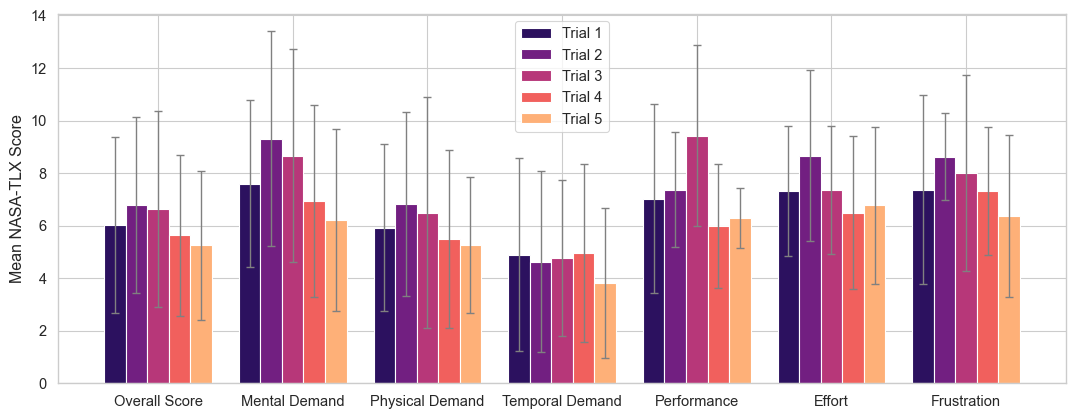

In [ ]:
scores = ("Overall Score", "Mental Demand", "Physical Demand", "Temporal Demand", "Performance", "Effort", "Frustration")
x = np.arange(1, len(scores) + 1, 1)
sns.set_theme(style='whitegrid', font_scale=1.2, context='paper')
palette = sns.color_palette("magma", 5)
sns.set_palette(palette)

multiplier = 0
margin = 0.1
width = (1 - 2 * margin)/5

fig, ax = plt.subplots()

fig.set_figwidth(13)

for trial, entry in tlx_trial_df.drop(["trial"], axis=1).iterrows():
    offset = width * multiplier + margin
    rects = ax.bar(x + offset, entry, width, label="Trial " + str(multiplier + 1))
    e = tlx_std_trial_df.drop(["trials"], axis=1).loc[trial] * 1.96 / np.sqrt(tlx_std_trial_df.shape[1])
    (_, caps, _) = ax.errorbar(x + offset, entry, e, linestyle='None', capsize=3, fmt="", color="grey", elinewidth=1)
    for cap in caps:
        cap.set_markeredgewidth(1)
    multiplier += 1

plt.ylabel("Mean NASA-TLX Score")

plt.legend()
ax.set_xticks(x + 2 * width + margin, scores)
plt.show()